# Import Modules

In [4]:
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_ind
from typing import List
import math
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import phate
import random
import sklearn.utils

# Connect to Database

In [5]:
# connect to database
DB_PARAM_FILEPATH = os.path.join('C'+os.getcwd()[1:], '..', 'db_connection_params.csv')
db_params = pd.read_csv(DB_PARAM_FILEPATH)
db_host = db_params.host.iloc[0]
db_user = db_params.username.iloc[0]
db_pass = db_params.password.iloc[0]
db_name = db_params.database.iloc[0]
db_table = db_params.table.iloc[0]

print('Connecting to database...')
cnx = mysql.connector.connect(user = db_user, password = db_pass, host = db_host, database = db_name)
cursor = cnx.cursor(buffered=True)
print('Done connecting to database.')

Connecting to database...
Done connecting to database.


# Read Articles From Database

In [6]:
# read articles into dataframe
print('reading "articles" table')
query = 'SELECT * FROM articles WHERE pub_date IS NOT NULL AND source IS NOT NULL AND article_title IS NOT NULL'
# mysql package technically isn't supported, but this works fine
articles = pd.read_sql(query, cnx)
print('done reading "articles" table')
articles

reading "articles" table
done reading "articles" table


C:\Users\eeday\AppData\Local\Temp\ipykernel_21624\1549451138.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  articles = pd.read_sql(query, cnx)


,pmc_id,archive_href,abstract_text,pub_date,source,article_title
0,PMC7284390,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,the csp cell surface protein microsatellite ma...,2020-05-08,Microorganisms,Identification of CSP Types and Genotypic Vari...
1,PMC10478028,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,abstractseveral environmental chemicals are su...,2022-11-18,Cereb Cortex Commun,Fetal blockade of nicotinic acetylcholine tran...
2,PMC6494343,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,abstractchronic pulmonary aspergillosis cpa is...,2019-04-19,Medicine (Baltimore),"Evaluation of Aspergillus IgG, IgM antibody fo..."
3,PMC8501721,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,backgroundautism spectrum disorder asd is a co...,2021-10-09,BMC Neurosci,A systematic review of common genetic variatio...
4,PMC9620685,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,background and aimstrategies to modify and adj...,2022-09-21,Autism Dev Lang Impair,Strategies in supporting inclusive education f...
...,...,...,...,...,...,...
8654,PMC10137878,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,parenting a child with autism spectrum disorde...,2023-04-21,Healthcare (Basel),Qualitative Investigation into the Perception ...
8655,PMC5085789,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,since involved in synaptic transmission and lo...,2016-10-22,Int J Mol Sci,Association Analysis of Noncoding Variants in ...
8656,PMC8421761,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,background autism spectrum disorder asd or aut...,2021-08-24,Front Psychiatry,"A Phase II Randomized, Double-Blind, Placebo-C..."
8657,PMC8464598,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,theory of mind tom deficits are common in chil...,2021-09-25,Transl Psychiatry,Do shapes have feelings? Social attribution in...


# Filter Articles
Need a set of articles without Aspergillus in title.

In [7]:
asd_search_terms = ['autis', 'asperger']

# filter out any articles which don't have autis* or asperger in title
filtered_articles = articles[articles["article_title"].str.contains('|'.join(asd_search_terms))]

# get a set of all articles with "Aspergillus" in title
asg_articles = articles[~articles['article_title'].str.contains('|'.join(asd_search_terms))]
filtered_articles

,pmc_id,archive_href,abstract_text,pub_date,source,article_title
1,PMC10478028,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,abstractseveral environmental chemicals are su...,2022-11-18,Cereb Cortex Commun,Fetal blockade of nicotinic acetylcholine tran...
3,PMC8501721,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,backgroundautism spectrum disorder asd is a co...,2021-10-09,BMC Neurosci,A systematic review of common genetic variatio...
4,PMC9620685,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,background and aimstrategies to modify and adj...,2022-09-21,Autism Dev Lang Impair,Strategies in supporting inclusive education f...
5,PMC8162135,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,this exploratory study aimed to explore the as...,2020-08-08,Autism,"Timing of diagnosis, depression and self-harm ..."
8,PMC10150704,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,importancesleep disorders are one of the most ...,2023-04-17,Front Psychiatry,Identification of atypical sleep microarchitec...
...,...,...,...,...,...,...
8643,PMC8686326,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,autism specific transition resources tres\naim...,2021-01-28,HRB Open Res,Study protocol for autism specific transition ...
8648,PMC10406950,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,despite many differences autism spectrum disor...,2023-08-07,Sci Rep,Association between increased anterior cingula...
8652,PMC6298000,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,background\nenvironmental factors can modify t...,2018-12-17,BMC Neurosci,Offline encoding impaired by epigenetic regula...
8653,PMC6529696,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,prebiotic dietary watersoluble fiber obtained ...,2019-03-07,J Clin Biochem Nutr,Dietary supplementation with partially hydroly...


# Extract Corpus
We need to extract all abstracts to create a corpus.

In [8]:
# extract corpus
abstracts = list(articles.abstract_text)
filtered_abstracts = list(filtered_articles.abstract_text)
asg_abstracts = list(asg_articles.abstract_text)

# Convert to Word Embeddings
We'll be using the Google News pre-trained word embeddings model.

In [55]:
WORD_EMBEDDINGS_FILEPATH = os.path.join('..', 'word_embeddings', 'GoogleNews-vectors-negative300.bin')
gn_vectors = KeyedVectors.load_word2vec_format(WORD_EMBEDDINGS_FILEPATH, binary=True)

Let's define a function which averages word embedding vectors across a text.

In [56]:
def get_text_avg(word_vectors: KeyedVectors, text: str) -> np.array:
    # get list of words in text
    wl = [i.strip() for i in text.split()]
    
    # initial word vector list
    wvl = []

    for word in wl:
        try:
            wvl.append(word_vectors[word])
        except KeyError:
            # word not present, continue
            continue
    
    return np.mean(np.array(wvl), axis=0)

And test it out on a few articles.

In [57]:
a0 = abstracts[0]
a1 = abstracts[1]
a2 = abstracts[2]
# a0 and a2 should be most similar
print(a0)
print(a1)
print(a2)
print()

we_a0 = get_text_avg(gn_vectors, a0)
we_a1 = get_text_avg(gn_vectors, a1)
we_a2 = get_text_avg(gn_vectors, a2)

print('a0 x a1: {0}'.format(cosine_similarity([we_a0], [we_a1])))
print('a0 x a2: {0}'.format(cosine_similarity([we_a0], [we_a2])))
print('a1 x a2: {0}'.format(cosine_similarity([we_a1], [we_a2])))

the csp cell surface protein microsatellite marker is useful for typing aspergillus fumigatus isolates and determining relationships at the subpopulation level because it has shown high discriminatory power in the present study 90 a fumigatus isolates from mexico mx argentina ar france fr and peru pe were identified through a phylogenetic analysis using the bena gene fragment and were typed with the csp microsatellite and the types were identified using the nomenclature recommended in the literature genetic variability was analyzed through haplotype diversity nucleotide diversity polymorphic sites and nucleotide differences between pairs of sequences the population structure was evaluated using the tajima’s d statistic no new csp types were recorded in the mx fr and pe isolates while in the ar isolates two new csp types were identified t25 and t26 the most common csp types in the studied populations were t01 t02 t03 and t04a these results are consistent with findings in other countries

## Simple Average Word Embeddings Test
We need to validate our word embeddings as a metric for text similarity. To do so, we will take advantage of the included articles on Aspergillus and perform a simple t-test.

In [58]:
non_asg_we = [get_text_avg(gn_vectors, i) for i in random.sample(filtered_abstracts, 800)]
asg_we = [get_text_avg(gn_vectors, i) for i in random.sample(asg_abstracts, 800)]

In [59]:
# within-group cosine similarity
wig_cs = []

for i in range(len(non_asg_we)-1):
    for j in range(i, len(non_asg_we)):
        wig_cs.append(cosine_similarity([non_asg_we[i]], [non_asg_we[j]]))

for i in range(len(asg_we)-1):
    for j in range(i, len(asg_we)):
        wig_cs.append(cosine_similarity([asg_we[i]], [asg_we[j]]))

len(wig_cs)

640798

In [60]:
# between-group cosine similarity
bg_cs = []

for i in range(len(non_asg_we)):
    for j in range(len(asg_we)):
        bg_cs.append(cosine_similarity([non_asg_we[i]], [asg_we[j]]))

len(bg_cs)

640000

In [61]:
ttest_ind(wig_cs, bg_cs)

TtestResult(statistic=array([[2.97598413]]), pvalue=array([[0.00292055]]), df=array([[1280796.]]))

# Perform K-Means Clustering - Validation

To make this easier, we'll be using some code from https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/.

In [62]:
def mbkmeans_clusters(
	X,
    k: int,
    mb: int,
    print_silhouette_values: bool, 
    seed: int = 42
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb, random_state=seed).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_, silhouette_score(X, km.labels_)

Let's get our word embeddings for all documents:

In [63]:
all_we = [get_text_avg(gn_vectors, i) for i in abstracts]

In [64]:
# select a cluster number
max_k = 20

sil_scores_df = pd.DataFrame({
    'k': [i for i in range(2, max_k+1)],
    'silhouette_score_mean': [math.inf for i in range(2, max_k+1)],
    'silhouette_score_var': [math.inf for i in range(2, max_k+1)],
    'silhouette_score_se':  [math.inf for i in range(2, max_k+1)],
    'wcss_mean': [math.inf for i in range(2, max_k+1)],
    'wcss_var': [math.inf for i in range(2, max_k+1)],
    'wcss_se':  [math.inf for i in range(2, max_k+1)]
})

n_tests = 30

for k in range(2, max_k+1):
    # need to get an average of silhouette scores with varying random seed
    print(f'K: {k}')
    sil_scores_list = []
    wcss_list = []
    for seed in range(2, 2+n_tests+1):
        clustering, cluster_labels, sil_score = mbkmeans_clusters(X=all_we,
                                                    k=k,
                                                    mb = 500,
                                                    print_silhouette_values=False,
                                                    seed=seed)
        sil_scores_list.append(sil_score)
        wcss_list.append(clustering.inertia_)

    sil_score_mean = np.mean(sil_scores_list)
    sil_score_var = np.var(sil_scores_list)
    sil_score_se = np.std(sil_scores_list)/math.sqrt(n_tests)

    sil_scores_df.loc[sil_scores_df['k'] == k, 'silhouette_score_mean'] = sil_score_mean
    sil_scores_df.loc[sil_scores_df['k'] == k, 'silhouette_score_var'] = sil_score_var
    sil_scores_df.loc[sil_scores_df['k'] == k, 'silhouette_score_se'] = sil_score_se

    wcss_mean = np.mean(wcss_list)
    wcss_var = np.var(wcss_list)
    wcss_se = np.std(wcss_list)/math.sqrt(n_tests)

    sil_scores_df.loc[sil_scores_df['k'] == k, 'wcss_mean'] = wcss_mean
    sil_scores_df.loc[sil_scores_df['k'] == k, 'wcss_var'] = wcss_var
    sil_scores_df.loc[sil_scores_df['k'] == k, 'wcss_se'] = wcss_se

    print()

K: 2
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:1398.783596488934
For n_clusters = 2
Silhouette coefficient: 0.17
Inertia:1404.541002912264
For n_clusters = 2
Silhouette coefficient: 0.17
Inertia:1403.4479151615615
For n_clusters = 2
Silhouette coefficient: 0.08
Inertia:1587.716611211921
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:1399.6224001036062
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:1396.7500741204524
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:1397.989872601577
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:1396.3152766273524
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:1404.9570027600907
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:1397.0291011944146
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:1396.3425376122123
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:1396.3148601094913
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:1396.7506602592216
For n_clusters = 2
Silho

In [65]:
sil_scores_df

,k,silhouette_score_mean,silhouette_score_var,silhouette_score_se,wcss_mean,wcss_var,wcss_se
0,2,0.159383,0.000327,0.003301,1412.801602,2884.587070,9.805759
1,3,0.117192,0.001398,0.006825,1334.558814,450.547979,3.875341
2,4,0.095826,0.001077,0.005993,1275.989802,622.006986,4.553413
3,5,0.085371,0.000607,0.004498,1231.287721,743.692026,4.978929
4,6,0.079459,0.000134,0.002110,1192.937403,269.500028,2.997221
5,7,0.071424,0.000052,0.001314,1174.371318,211.169299,2.653107
6,8,0.062898,0.000049,0.001272,1150.129979,506.026580,4.107013
7,9,0.056890,0.000083,0.001666,1137.332014,517.172861,4.151999
8,10,0.054445,0.000082,0.001652,1118.283703,1073.012731,5.980559
9,11,0.052093,0.000026,0.000933,1105.755016,1085.574032,6.015463


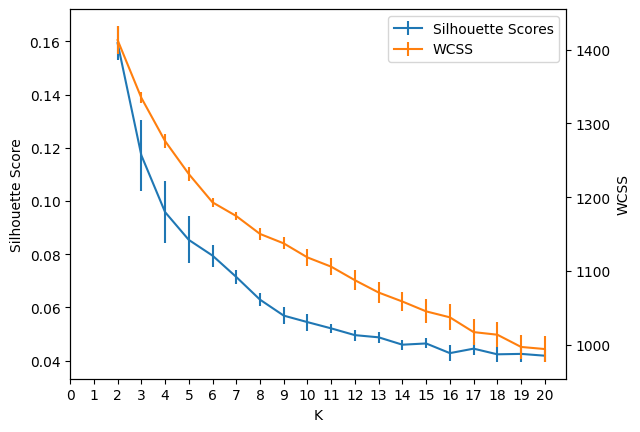

In [66]:
fix, ax = plt.subplots()

twin1 = ax.twinx()

p1 = ax.errorbar(sil_scores_df.k,
             sil_scores_df.silhouette_score_mean,
             yerr=1.96*sil_scores_df.silhouette_score_se,
             label = 'Silhouette Scores',
             color='C0')
p2 = twin1.errorbar(sil_scores_df.k,
             sil_scores_df.wcss_mean,
             yerr=1.96*sil_scores_df.wcss_se,
             label = 'WCSS',
             color='C1')

ax.set(xlabel='K', ylabel='Silhouette Score')
twin1.set(ylabel='WCSS')

ax.legend(handles = [p1, p2])

plt.xticks(range(max_k+1))
plt.show()

Based on the silhouette plot above, let's try picking k=6.

In [68]:
num_clusters = 6

In [69]:
clustering, cluster_labels, sil_score = mbkmeans_clusters(X=all_we,
                                            k=num_clusters,
                                            mb = len(all_we),
                                            print_silhouette_values=True,
                                            seed=13)


For n_clusters = 6
Silhouette coefficient: 0.08
Inertia:1179.4223437256978
Silhouette values:
    Cluster 0: Size:941 | Avg:0.13 | Min:-0.05 | Max: 0.29
    Cluster 1: Size:1808 | Avg:0.11 | Min:-0.07 | Max: 0.27
    Cluster 2: Size:1582 | Avg:0.09 | Min:0.01 | Max: 0.21
    Cluster 4: Size:1546 | Avg:0.07 | Min:-0.02 | Max: 0.19
    Cluster 5: Size:1180 | Avg:0.05 | Min:-0.08 | Max: 0.22
    Cluster 3: Size:1602 | Avg:0.02 | Min:-0.05 | Max: 0.14


Let's now get the most representative tokens per cluster.

In [70]:
print('most representative terms per cluster (based on centroids):')
for i in range(num_clusters):
    tokens_per_cluster = ''
    most_representative = gn_vectors.most_similar(positive = [clustering.cluster_centers_[i]], topn = 5)
    for t in most_representative:
        tokens_per_cluster += f'{t[0]} '
    print(f'Cluster {i}: {tokens_per_cluster}')

most representative terms per cluster (based on centroids):
Cluster 0: severe_hepatic_dysfunction PLX_STROKE_targeting receiving_XGEVA Cerebral_palsy_involves PCNSL 
Cluster 1: Thorough_cooking_kills fusion_enhancers Thoroughly_cooking_eggs By_Elise_Viebeck cyclic_AMP_cAMP 
Cluster 2: %_#F########_9v.jsn By_Jonas_Elmerraji By_Laurelle_Gilbert %_#F########_3v.jsn By_Christine_Fenno 
Cluster 3: By_Jonas_Elmerraji By_Laurelle_Gilbert Club_Stairways_Comprehensive By_Elise_Viebeck %_#F########_9v.jsn 
Cluster 4: By_Laurelle_Gilbert By_Jonas_Elmerraji By_Elise_Viebeck DIRECTORS_OF_CAPITAL_CORP. By_Christine_Fenno 
Cluster 5: DNA_methylation_patterns Genetic_predisposition glial_tumors underlying_pathophysiology phenotypic_expression 


Utter nonsense. How about the most representative documents?

In [72]:
for i in range(num_clusters):
    most_representative_docs = np.argsort(
        np.linalg.norm(all_we - clustering.cluster_centers_[i], axis=1)
    )
    print(f'Cluster {i}')
    for d in most_representative_docs[:3]:
        print(abstracts[d])
        print('---------------------')
    print()

Cluster 0
invasive pulmonary aspergillosis ipa has been recognized as a possible secondary infection complicating coronavirus disease 2019 covid19 and increasing mortality the aim of this review was to report and summarize the available data in the literature concerning the incidence pathophysiology diagnosis and treatment of covid19associated pulmonary aspergillosis capa currently the incidence of capa is unclear due to different definitions and diagnostic criteria used among the studies it was estimated that approximately 86 2062383 of mechanically ventilated patients were diagnosed with either proven probable or putative capa classical host factors of invasive aspergillosis are rarely recognized in patients with capa who are mainly immunocompetent presenting with comorbidities while the role of steroids warrants further investigation direct epithelial injury and diffuse pulmonary micro thrombi in combination with immune dysregulation hyper inflammatory response and immunosuppressive

Yup, there it is!
These actually appear to be segregating in a much more reasonable way!
Now let's plot this.

## K-Means Plotting - Validation

In [27]:
u_cluster_labels = np.unique(cluster_labels)

In [28]:
all_colors = list(mcolors.BASE_COLORS.keys())
print(len(all_colors))
all_labels = ['o', 'x', '+', 'D', 'v', '1', 's']
color_set = []
marker_set = []
for i in u_cluster_labels:
    color_set.append(all_colors[i % len(all_colors)])
    marker_set.append(all_labels[i % len(all_labels)])
print(color_set)
print(marker_set)

8
['b', 'g', 'r', 'c', 'm', 'y']
['o', 'x', '+', 'D', 'v', '1']


In [29]:
len(all_we[0])

300

To visualize these 300D vectors, we need to use a dimensionality reduction algorithm that preserves high-order structure. Let's try using PHATE.

In [30]:
po = phate.PHATE()
ph_all_we = po.fit_transform(np.array(all_we))

Calculating PHATE...
  Running PHATE on 8659 observations and 300 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.31 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.76 seconds.
    Calculating affinities...
    Calculated affinities in 0.14 seconds.
  Calculated graph and diffusion operator in 5.23 seconds.
  Calculating landmark operator...
    Calculating SVD...


c:\Users\eeday\AppData\Local\Programs\Python\Python312\Lib\site-packages\graphtools\graphs.py:290: RuntimeWarning: Detected zero distance between 163 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
c:\Users\eeday\AppData\Local\Programs\Python\Python312\Lib\site-packages\graphtools\graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated SVD in 0.85 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.23 seconds.
  Calculated landmark operator in 7.61 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 3.92 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.20 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.15 seconds.
Calculated PHATE in 21.14 seconds.


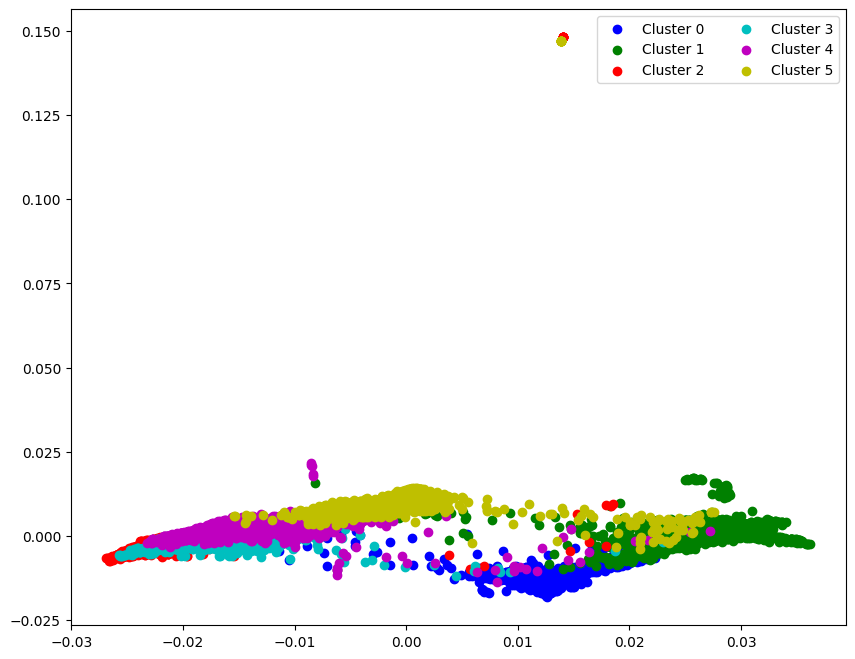

In [33]:
plt.figure(figsize=(10,8))
for i in u_cluster_labels[0:]:
    plt.scatter(ph_all_we[cluster_labels == i, 0], ph_all_we[cluster_labels == i, 1], label=f'Cluster {i}', c=color_set[i])
plt.legend(fontsize = 10, ncol = 2)
plt.show()

Although the clustering that PHATE uses is different from the way that K-Means tends to cluster, it appears to be clustering in a reasonable way.

# K-Means Clustering - Analysis

Since two of our five clusters relate to *Aspergillus* rather than autism, we'll bring down the cluster number to four to analyze the autism articles.

In [8]:
filtered_k = 4

And let's make sure we're working with the full corpus:

In [31]:
non_asg_we = [get_text_avg(gn_vectors, i) for i in filtered_abstracts]

Cluster the corpus:

In [35]:
clustering, cluster_labels, sil_score = mbkmeans_clusters(X=non_asg_we,
                                            k=filtered_k,
                                            mb = len(non_asg_we),
                                            print_silhouette_values=True,
                                            seed=13)

For n_clusters = 4
Silhouette coefficient: 0.08
Inertia:861.1934607640751
Silhouette values:
    Cluster 0: Size:673 | Avg:0.12 | Min:-0.05 | Max: 0.27
    Cluster 1: Size:2956 | Avg:0.09 | Min:-0.01 | Max: 0.21
    Cluster 2: Size:1070 | Avg:0.07 | Min:-0.07 | Max: 0.23
    Cluster 3: Size:1830 | Avg:0.06 | Min:-0.02 | Max: 0.15


Most representative tokens for each cluster:

In [36]:
print('most representative terms per cluster (based on centroids):')
for i in range(filtered_k):
    tokens_per_cluster = ''
    most_representative = gn_vectors.most_similar(positive = [clustering.cluster_centers_[i]], topn = 5)
    for t in most_representative:
        tokens_per_cluster += f'{t[0]} '
    print(f'Cluster {i}: {tokens_per_cluster}')

most representative terms per cluster (based on centroids):
Cluster 0: PLX_STROKE_targeting severe_hepatic_dysfunction receiving_XGEVA Cerebral_palsy_involves fusion_enhancers 
Cluster 1: By_Jonas_Elmerraji By_Laurelle_Gilbert %_#F########_9v.jsn %_#F########_3v.jsn By_Christine_Fenno 
Cluster 2: DNA_methylation_patterns Genetic_predisposition glial_tumors phenotypic_expression underlying_pathophysiology 
Cluster 3: Genetic_predisposition neuropsychological_impairments By_Laurelle_Gilbert By_Jonas_Elmerraji familial_clustering 


In [34]:
for i in range(filtered_k):
    most_representative_docs = np.argsort(
        np.linalg.norm(non_asg_we - clustering.cluster_centers_[i], axis=1)
    )
    print(f'Cluster {i}')
    for d in most_representative_docs[:3]:
        print(filtered_abstracts[d])
        print('---------------------')
    print()

Cluster 0
invasive pulmonary aspergillosis ipa has been recognized as a possible secondary infection complicating coronavirus disease 2019 covid19 and increasing mortality the aim of this review was to report and summarize the available data in the literature concerning the incidence pathophysiology diagnosis and treatment of covid19associated pulmonary aspergillosis capa currently the incidence of capa is unclear due to different definitions and diagnostic criteria used among the studies it was estimated that approximately 86 2062383 of mechanically ventilated patients were diagnosed with either proven probable or putative capa classical host factors of invasive aspergillosis are rarely recognized in patients with capa who are mainly immunocompetent presenting with comorbidities while the role of steroids warrants further investigation direct epithelial injury and diffuse pulmonary micro thrombi in combination with immune dysregulation hyper inflammatory response and immunosuppressive

Let's use PHATE to approximate the shape of our clusters.

In [25]:
po = phate.PHATE()
ph_all_we = po.fit_transform(np.array(non_asg_we))

Calculating PHATE...
  Running PHATE on 800 observations and 300 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.36 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.42 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 0.66 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.08 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.29 seconds.
Calculated PHATE in 1.48 seconds.
